<a href="https://colab.research.google.com/github/rajkstats/uplimit_langchain/blob/main/%5BRAJK%5D_Langchain_Week2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the course: [LLM Apps with Langchain](https://uplimit.com/course/llm-apps-with-langchain) and is created by Sidharth Ramachandran as the project for Week 2 of the course.

# Let's build "InfoScout" - a web research agent that prepares a detailed report for us on any topic and continuously adapts it based on feedback.

<a href="https://ibb.co/MNk1LJh"><img src="https://i.ibb.co/F74YtdW/DALL-E-2024-08-01-10-13-13-A-futuristic-agent-conducting-web-research-for-a-product-called-Info-Scou.webp" alt="DALL-E-2024-08-01-10-13-13-A-futuristic-agent-conducting-web-research-for-a-product-called-Info-Scou" border="0"></a><br /><a target='_blank' href='https://de.imgbb.com/'></a><br />

We rely on web searches to perform a lot of tasks in our daily life. It might be mundane things like looking up addresses and movie show times or more involved like performing a market study or job research. Inspired by the likes of [Perplexity](https://www.perplexity.ai/) we would like to create our own personalized web research agent that executes these tasks for us. This can be extremely beneficial in terms of saving our time and probably find some interesting information that we might have otherwise missed out!

In the process of building InfoScout, we will make use of the Langgraph framework that is part of the Langchain library.

# 👨‍🎓 Learner Project

Your goal in this project is to build a web research assistant that is capable of writing reports or articles based on research performed on the internet. We provide you with some basic scaffolding to create the agent but also suggest 📝 `Learner Tasks` where you have to complete the prompt or code.

# Step 0 - Pre-requisites

In [45]:
%pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph==0.1.17 tavily-python langchainhub gradio cohere pymongo python-dotenv

One of the main tools that we will use in building this agent is a web search engine. By default, LLMs do not have access to the internet and we need to provide them with this information. There are a lot of providers like Perplexity, SERP API and Tavily - that we will use in this project.

Please sign-up for an account with [Tavily](https://tavily.com/) We will make use of Tavily and then navigate to the Overview page where you will find the API key. With a free account, you can make upto 1000 API requests per month and this should be more than sufficient for this project. Please add the TAVILY_API_KEY as another security key in the left tab of the Colab notebook as shown in the Week 1 project.

<a href="https://ibb.co/1qLRGh4"><img src="https://i.ibb.co/d2rk41H/Screenshot-2024-08-01-at-10-19-23.png" alt="Screenshot-2024-08-01-at-10-19-23" border="0"></a><br /><a target='_blank' href='https://de.imgbb.com/'></a><br />

If you have already completed the Week 1 project then your OPENAI_API_KEY would already be saved as part of the Colab environment, if not please take the necessary steps.

# Step 1 - Initializing the individual components of our Agent graph

The best way to think about agents is to break down the goal into sub-tasks and approach it similarly to how you would as a human being. With the critial difference being that each sub-task is performed by an LLM. For instance, let's consider how we can break down the goal of generating a research article -

1. Depending on the topic, we would think about search terms or queries that will lead us to more information about the topic.
2. We also have to actually execute those search queries - typically we would do that along with the first step as a human being but when working with LLMs, this can be treated as a seperate step.
3. Based on the information we have gathered, we could generate our first draft document.
4. Once you have gathered enough information, you would then like to get a review of the document from your colleagues or supervisor to make sure that you're going in the right direction.
5. Finally, you would use the feedback you received to refine and iterate on your draft - making additional searches and research when necessary.

In this project, we will translate this process into code with the help of Langraph - a library that is part of Langchain and allows us to define various flows of information. This can also be achieved by writing simple logical steps and loops but Langgraph provides us with additional functionality like state storage and more that makes it worthwhile to use it. It also makes it much more extensible as you will see during the project.

We have identified the high-level workflow as outlined above. Let us start by defining the individual components. I found this to be an easier way of understanding how to make use of Langgraph. As we define each function, we will also be able to identify state variables that we will need and we can add that to the AgentState object. Let's see what we mean.

First step is to define the model that we are going to use for our workflow.

In [46]:
from langchain_openai import ChatOpenAI
from google.colab import userdata

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=userdata.get('OPENAI_API_KEY'))

Let's think about the first step in our identified workflow - the creation of search queries. We delegate this to an LLM using the prompt below.

In [47]:
RESEARCH_PROMPT = """You are an expert web researcher who understands how Google works and can come up with \
multiple search queries for a given task.

You will be provided with the original user task or topic and your job is to identify the three best search queries \
that will retrieve the most information to complete that task. Your goal is to ensure different aspects of the task \
are covered and in the end we can provide a comprehensive overview to solve the problem. \

In some cases, you might be provided with additional tasks or aspects that the user wants to improve \
so please adapt your search queries based on this.
"""

We want the LLM to return the identified search queries in a structured object because we would like to use it for the next step in our workflow. Please take note of the following important points:

1. We define a base `Queries` class that represents a list of the search strings returned by the LLM.
2. We make use of the `with_structured_output` functionality as discussed in the lecture session to force the LLM to return a well formatted response that we can easily read into the object.
3. After the search queries are returned, we make use TAVILY - a Search API provider to retrieve the results for our search term. This is the equivalent of performing Google searches yourself. For this you would need to have access to the TAVILY_API_KEY. You can sign-up for the Tavily API by clicking [here](https://app.tavily.com/sign-in) and follows the steps as shown in the screenshot.

In [48]:
from langchain_core.pydantic_v1 import BaseModel
from typing import TypedDict, Annotated, List

class Queries(BaseModel):
    queries: List[str]

In [49]:
import getpass, os

os.environ["TAVILY_API_KEY"] = getpass.getpass()

··········


In [75]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage


# Initialize the TavilySearchResults tool
tavily_tool = TavilySearchResults(
    max_results=1,
    include_answer=True,
    include_raw_content=True,
    include_images=True
)


def research_node(state: AgentState):
    print("Research Agent executing ...")
    input_message = "User query: " + state['user_query']
    if state['review_comments'] is not None and state['review_comments'] != "":
        input_message = input_message + "\n Review Comments: " + state['review_comments']

    node_search_queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PROMPT),
        HumanMessage(content=input_message)
    ])

    search_queries = state['search_queries'] or []
    search_queries.append(node_search_queries)
    state['search_queries'] = search_queries

    search_results = state['search_results'] or []
    for q in node_search_queries.queries:
        response = tavily_tool.run(q)
        if isinstance(response, list):
            for r in response:
                if 'content' in r:
                    search_results.append(r['content'])
        elif isinstance(response, dict) and 'content' in response:
            search_results.append(response['content'])

    return {"search_results": search_results}

You will notice that we have used a function parameter `AgentState` where we store the search queries as well as the search results. This is the way in which Langraph allows us to do state management. Since we are designing workflows, it's important that outputs generated by one node should actually be available for subsequent node to work on or use. In this case, the research node will give the search results that the writer node needs in order to create the draft. In langraph, we achieve this by storing the values in the `AgentState` class. We can control which elements should be part of the state and keep adapting it as we add new nodes and operations to our workflow.

In [76]:
from typing import TypedDict, Annotated, List

class AgentState(TypedDict):
    user_query: str
    search_queries: List[str]
    search_results: List[str]
    draft_report: str
    review_comments: str
    draft_number: int
    max_reviews: int

If we find the need to create other state variables then we can come back and adapt it. In the next step, let's create the prompt that will generate the search queries.

In the `research_node`, we have actually completed both Step1 and Step2 of the sub-tasks that we had outlined before. Let's move onto the draft generation step - the goal of this sub-task is to generate a detailed research report based on the retrieved search results.

We create the LLM prompt for writing the article and as context we have to provide the search information that has been retrieved from the previous step. This is retrieved from the `AgentState` where we had already stored it. In addition, we add a variable to determine the number of times a draft is generated. We will make use of this later to control the flow. We initialize the variable `revision_number` to 1 once we have written the first draft. Each subsequent call of this function will also augment the revision_number by one.

In [77]:
WRITER_PROMPT = """You are an expert web assistant who can easily parse out nuggets of valuable information from
mutliple web pages containing information.
Along with the user task or problem, you are also provided a lot of information from crawled web pages and you
have to generate the best research report that can complete the user task or offer a solution to the problem.
Your report has to be insightful and provide the user with information that they were not aware of before.
Your job is to make the life of the user easier so try to give answers rather than options.
Utilize all the information below as needed:

------

{content}"""

In [78]:
def writer_node(state: AgentState):
    print ("Writing Agent executing ...")
    search_information = "\n\n".join(state['search_results'] or [])
    user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
    messages = [SystemMessage(content=WRITER_PROMPT.format(content=search_information)),
                user_message]
    response = model.invoke(messages)
    draft_number = 0
    if (state.get("draft_number") is not None):
      draft_number = state.get("draft_number")
    return {
        "draft_report": response.content,
        "draft_number": draft_number + 1
    }

As before, we store the drafted content in the state variable called `draft_report` and additionally also store the `draft_number`. This draft_report is what will be used in our next step.

We have defined the research and writer sub-tasks already and now it's time to define the review sub-task. We would certainly do this when writing a report ourselves but probably not so early in the process. Typically, we would prefer to write a more complete first version before having it reviewed - but each of our styles could also be different!

However, when working with LLMs and agentic workflows, one of the common design patterns is to use reflection, or self-reflection. The idea behind it is that LLMs are not great at generating the best output in a start to finish manner. However, when asked to critique their own work, they are able to identify potential flaws and are capable of adapting the output to become better.

Let's go ahead and define the reflection prompt and create the node.

In [79]:
REFLECTION_PROMPT = """Assume that you are a senior leader in an established technology company in the USA. You have requested \
your virtual assistant or intern to provide you with a short report or write-up based on a task or problem \
they are provided. The VA/Intern has done some web search and collated those results into a report.

Please evaluate whether the report correctly answers the user task or problem. Think through your critique step by step and
finally respond with very concise instructions on what additional information or aspects that you would like to have improved in the draft article."""

In [80]:
def reflection_node(state: AgentState):
    print ("Review Agent executing ...")
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft_report'])
    ]
    response = model.invoke(messages)
    return {"review_comments": response.content}

We have created the various sub-tasks - research, draft generation and review/ reflection. The next step is to design our flow and put in the place the necessary feedback loops.

Let's start by defining our graph and adding the nodes.

In [81]:
from langgraph.graph import StateGraph, END

research_graph = StateGraph(AgentState)
research_graph.add_node("researcher", research_node)
research_graph.add_node("writer", writer_node)
research_graph.add_node("reflect", reflection_node)

The next step is to define the workflow that we want. It's clear that our graph should start by doing the research, then use the results to write the first draft and then review it. This is what we define in our code -

In [82]:
research_graph.set_entry_point("researcher")
research_graph.add_edge("researcher", "writer")
research_graph.add_edge("writer", "reflect")
research_graph.add_edge("reflect", "researcher")

Finally, we put all of this together and compile it to make sure that we have correctly defined the graph.

In [83]:
researcher_agent = research_graph.compile()

We can also visualize our graph by printing what it looks like.

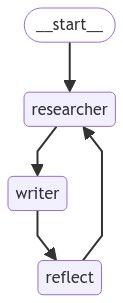

In [84]:
from IPython.display import Image, display

display(Image(researcher_agent.get_graph().draw_mermaid_png()))

One of the issues that you might notice in the graph as we have defined it is that it is a continuous loop. There is no defined logic or clause at which we can say that we are done and happy with the article. So if we try to run it as is, we will end up with a non-terminating workflow and a lot of LLM API costs!

Let's adapt our workflow to add a conditional edge. There are various ways in which we can define the conditional edge but let's start with a simple one that is purely based on the number of draft_version. If you remember, we have already tracked this number in the state and we can use that to create a conditional edge between the writer and reflect nodes.

We start by specifying a specific function called `agent_goal` to determine whether the agent has acieved it's goal. We will pass in a new variable called `max_reviews` that will be checked against the draft_number. If the maximm number of iterations has been achieved, then we say that agent goal has been achieved and do not continue further.

In [85]:
def agent_goal(state: AgentState):
  draft_number = state["draft_number"]
  max_reviews = state["max_reviews"]
  if draft_number > max_reviews:
    print ("End of Agent Execution")
    return "AGENT_END"
  else:
    print ("Continue Agent Execution")
    return "AGENT_CONTINUE"

We have to re-initilize our graph to take into account this new conditional edge. We replace the direct edge that we had between the writer and reflect nodes with the additional agent_goal.

In [86]:
from langgraph.graph import StateGraph, END

research_graph = StateGraph(AgentState)

# Add nodes
research_graph.add_node("researcher", research_node)
research_graph.add_node("writer", writer_node)
research_graph.add_node("reflect", reflection_node)

# Add edges
research_graph.set_entry_point("researcher")
research_graph.add_edge("researcher", "writer")
research_graph.add_conditional_edges("writer", agent_goal, {"AGENT_END": END, "AGENT_CONTINUE":"reflect"},)
research_graph.add_edge("reflect", "researcher")

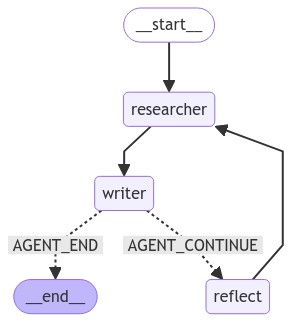

In [87]:
researcher_agent = research_graph.compile()
display(Image(researcher_agent.get_graph().draw_mermaid_png()))

You will observe that the new graph doesn't appear like a loop anymore and has a defined end point based on the AGENT_END and AGENT_CONTINUE conditions.

Let's try running the graph now for a maximum of two iterations to make sure that everything works.

# Step 2 - Running our agent

Let's call the agent now with our user question and see what the final report looks like. Particularly, we choose to stream the responses because we would like to be updated about what the agent is doing.

In [89]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGSMITH')
os.environ['LANGCHAIN_PROJECT'] = "INFOSCOUT"

In [90]:
output = researcher_agent.invoke({'user_query': "what is the back story or hidden secrets behind the internet website WebMD?",
                                  "max_reviews": 2,})

Research Agent executing ...
Writing Agent executing ...
Continue Agent Execution
Review Agent executing ...
Research Agent executing ...
Writing Agent executing ...
Continue Agent Execution
Review Agent executing ...
Research Agent executing ...
Writing Agent executing ...
End of Agent Execution


In [91]:
output

{'user_query': 'what is the back story or hidden secrets behind the internet website WebMD?',
 'search_results': ['WebMD is an American corporation which publishes online news and information about human health and well-being. [3] The WebMD website also includes information about drugs and is an important healthcare information website and the most popular consumer-oriented health site.',
  'In 2010, Sen. Chuck Grassley sent a letter to the site after finding that a WebMD quiz for depression, sponsored by pharmaceutical company Eli Lilly, was rigged to suggest everybody who took the ...',
  "Can a guy expect the bedroom key on date number three? WebMD's slideshow lays out the secrets of dating, love, and marriage according to women.",
  'These offerings are available within WebMD ONE, and in many cases, deeply integrated into core solutions—such as health coaching, Daily Habits, Rewards Engine, and more—allowing it to act as ONE true platform for everything your population needs to emp

# Step 3 - Adapting our agent

Let's start playing around with our agent and give it some additional capabilities. We started by specifying the maximum number of revisions that we want the agent to do. Instead, what if we wanted to present some of these revisions to a human being and let them decide if they would like further revisions.

To do this, we add an explicit interrupt to the workflow. Typically, this is specified using the `interrup_before` command. In this case, we don't want the reflection step to happen unless the human user wants it to happen. We only need to compile a different version of our graph with `interrupt_before`.

## 📝 Learner Task:

Please adapt the `AgentState` class to accomodate the new functionality that we would like to add. We want to rely on a `human_review` to decide whether to continue with a review process and not based on a certain maximum number of reviews.

In [111]:
from typing import TypedDict, Annotated, List

class AgentState(TypedDict):
    user_query: str
    search_queries: List[str]
    search_results: List[str]
    draft_report: str
    review_comments: str
    human_review: str

## 📝 Learner Task:

In the next step, we need to adapt the `reflection_node` to perform an LLM-based review only when our user asks for it. In some cases, the user might also want to provide their own comments or feedback based on which the agent should adapt the behaviour. Please adapt the `reflection_node` function to implement this new functionality.

Note: this depends on the `interrupt` step that we will add to the graph which we discuss in the project kick-off and in the next section, so please take that into account.

In [112]:
# Adapt the reflection_node to not make LLM calls if the human review has already been provided

def reflection_node(state: AgentState):
    print ("Review Agent executing ...")
    if state['human_review'] is not None and state['human_review'] != "":
      return {"review_comments": state['human_review']}
    else:
      messages = [
          SystemMessage(content=REFLECTION_PROMPT),
          HumanMessage(content=state['draft_report'])
      ]
      response = model.invoke(messages)
      return {"review_comments": response.content}

Let's go ahead with the graph definition. We call this a new graph `human_research_graph` to indicate the human-in-the-loop aspect. You can see that we have the same nodes as before and the only change is that we do not have the conditional edge any longer. The reason for this is because we will add the `interrupt_before` which will replace the human instead of the previous conditional element.

In [113]:
from langgraph.graph import StateGraph, END

human_research_graph = StateGraph(AgentState)

# Add nodes
human_research_graph.add_node("researcher", research_node)
human_research_graph.add_node("writer", writer_node)
human_research_graph.add_node("reflect", reflection_node)

# Add edges
human_research_graph.set_entry_point("researcher")
human_research_graph.add_edge("researcher", "writer")
human_research_graph.add_edge("writer", "reflect")
human_research_graph.add_edge("reflect", "researcher")

Let's go ahead and compile the graph. There are two important things you will notice here:

1. `interrupt_before` - this takes existing node or nodes as argument and will forecefully interrupt the execution of the graph before that node is reached. The resumption of the graph processing will have to be handled by our program logic. In this case, we define the interrup before 'reflect' node as we want to check with the user what they would like to do.
2. `checkpointer` - this is an additional argument that is required when working with interrupts and also to take care of multiple states that a graph might have. When the graph is interrupted, it must also save all the information in it's current state which can be pulled back when required. The checkpointer saves this state information in a local SQLITE database that is running in memory. In addition, you can have multiple users of the app each of whom might pause graph execution. The state variables must also not be mixed up and that's another reason why having the checkpointer is essential.

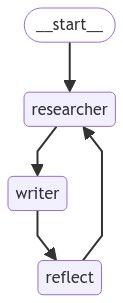

In [114]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
mod_researcher_agent = human_research_graph.compile(checkpointer=memory,
                                                    interrupt_before=["reflect"])

display(Image(mod_researcher_agent.get_graph().draw_mermaid_png()))

Let's try out the whole graph with the interrupt by running it directly before building the app.

In [115]:
output = mod_researcher_agent.invoke({'user_query': "what is the back story or hidden secrets behind the internet website WebMD?"},
                                     config = {"configurable": {"thread_id": 1}})

Research Agent executing ...
Writing Agent executing ...


You will already see that the graph stops execution after the writing node and before the reflect node has started. An initial draft report would have been generated as shown below.

In [118]:
from IPython.display import Markdown
display(Markdown(output['draft_report']))

The back story of WebMD is quite interesting and involves the formation of Healtheon Corporation in December 1995. However, the company took its present shape in 1999 after merging with WebMD, Inc. The legal history of WebMD Corporation began with these two enterprises cofounding the company. WebMD is a public company trading on the NASDAQ, indicating its growth and success in the market.

Additionally, WebMD has been a valuable resource for health information for many years. It provides a wide range of medical information, resources, and tools for both healthcare professionals and the general public. The website covers various health topics, conditions, treatments, and medications, making it a go-to source for reliable health information.

Moreover, WebMD has played a significant role in educating the public about various health issues, including Alzheimer's disease. One controversial theory associated with Alzheimer's disease involves aluminum, which was suspected when researchers found traces of this metal in the body. WebMD has been instrumental in disseminating information about such research findings and helping people understand the potential risks and implications.

In conclusion, the hidden secrets behind WebMD lie in its evolution from the merger of Healtheon Corporation and WebMD, Inc., its role as a trusted source of health information, and its contribution to raising awareness about important health issues like Alzheimer's disease and the potential impact of substances like aluminum.

This is the point at which we need to identify logic for handling the interrupt. Let's hard-code it for now to see how it works. What we are doing in the following step is as follows:

1. Get the configuration for the specific thread that we are interested in. `thread_id` is our current way to identify each new execution of the graph.
2. We have access to the state variables from the checkpoint and can actually make any changes. In this case, please update the state variable that you used for the human_review.

In [119]:
## Get the config based on the thread_id
config = {"configurable": {"thread_id": 1}}

## View the state variables
mod_researcher_agent.get_state(config).values

{'user_query': 'what is the back story or hidden secrets behind the internet website WebMD?',
 'search_results': ['WebMD is a public company trading on the NASDAQ. Forming the Corporation in 1995. The legal history of WebMD Corporation began in December 1995 with the formation of Healtheon Corporation, but the company did not take its present shape until the 1999 merger with WebMD, Inc. In a sense, the men who launched these two enterprises cofounded today ...',
  "3 min read. Aluminum. One of the most publicized and controversial theories concerns aluminum, which became a suspect in Alzheimer's disease when researchers found traces of this metal in the ...",
  "They're based on the study of healthy, happy couples and our changing gender roles. Secret No. 1: Women appreciate a guy with a sensitive side, especially when they're upset. Put your arm around ..."],
 'draft_report': "The back story of WebMD is quite interesting and involves the formation of Healtheon Corporation in December 

## 📝 Learner Task:

Please update the state variable to pass in any human review comments

In [120]:
## Make necessary changes to the state variable to pass in the human review comments
mod_researcher_agent.update_state(config, {"human_review": "Can you focus more on the business practices of the company as well in the article?"})

## You can confirm that the update of state has happened
mod_researcher_agent.get_state(config).values

{'user_query': 'what is the back story or hidden secrets behind the internet website WebMD?',
 'search_results': ['WebMD is a public company trading on the NASDAQ. Forming the Corporation in 1995. The legal history of WebMD Corporation began in December 1995 with the formation of Healtheon Corporation, but the company did not take its present shape until the 1999 merger with WebMD, Inc. In a sense, the men who launched these two enterprises cofounded today ...',
  "3 min read. Aluminum. One of the most publicized and controversial theories concerns aluminum, which became a suspect in Alzheimer's disease when researchers found traces of this metal in the ...",
  "They're based on the study of healthy, happy couples and our changing gender roles. Secret No. 1: Women appreciate a guy with a sensitive side, especially when they're upset. Put your arm around ..."],
 'draft_report': "The back story of WebMD is quite interesting and involves the formation of Healtheon Corporation in December 

Once you have made the necessary changes to the state, you can resume the graph processing by calling `invoke` again without passing any input but with the same config. This resumes the graph processing.

In [121]:
output = mod_researcher_agent.invoke(None, config)

Review Agent executing ...
Research Agent executing ...
Writing Agent executing ...


You will notice that the graph continued to execute and went back to the research and write nodes and then was interrupted again before the next call to the reflect node. So we are achieving the same functionality as before but with a human-in-the-loop intervention. You can view the adjusted draft article as shown below:

In [122]:
from IPython.display import Markdown
display(Markdown(output['draft_report']))

The back story of WebMD dates back to 1995 when the company was formed as Healtheon Corporation. However, the company took its present shape in 1999 after merging with WebMD, Inc. The legal history of WebMD Corporation began with the formation of Healtheon Corporation in December 1995. The company is based in Elmwood Park, New Jersey, and is best known for its consumer-focused healthcare information website. In addition to providing health information to consumers, WebMD also offers transaction and technology solutions for physicians, providers, and health plans through its WebMD Health unit.

One interesting fact about WebMD is that it is a public company trading on the NASDAQ. This means that the company's shares are available for purchase by the public on the stock exchange. This indicates that WebMD is a well-established and recognized company in the healthcare information industry.

Furthermore, WebMD recently announced the launch of WebMD PracticePro, a new platform designed to help medical practices attract, retain, and engage patients. This new feature-rich platform demonstrates WebMD's commitment to providing innovative solutions for healthcare providers and further solidifies its position as a leader in the healthcare information sector.

In conclusion, the hidden secrets behind WebMD lie in its evolution from Healtheon Corporation to the present-day WebMD Corporation, its status as a public company, and its continuous efforts to provide valuable healthcare information and solutions to consumers and healthcare providers alike.

We ran the modified graph by simulating a human-in-the-loop interruption and manually passing in the new state values. Let's now integrate this into a product and see how it will behave with actual user interaction.

## 📝 Learner Task:

Please create a Gradio front-end that incporporates the following functions:

1. `research_report`: a function that triggers the first graph execution and returns the first version of the draft article.
2. `do_human_review`: a function that takes human feedback and uses that to continue with the graph exection. It returns the next draft version of the article.
3. `do_AI_review`: a function that requests an LLM to do a review and continues with the graph execution. It also returns the next draft version of the article but after an AI review.

One critical aspect to take care of is creating the `thread_id` which is a new random integer uniquely used for each user request. We have already provided the necessary scaffolding for the gradio components and request you to complete the functions as defined above.

Let's create a usable front-end for testing this new agent, which can also be exposed to potential users. We make use of Gradio to code this functionality but it could be any front-end platform.

In [123]:
import random
import gradio as gr

mod_researcher_agent = human_research_graph.compile(checkpointer=memory,
                                              interrupt_before=["reflect"])

def research_report(user_query, thread_id):
  ## Create a new thread_id to track this request
  agent_thread = random.randint(0, 1000)
  ## Add it to the Gradio state variable which helps to maintain this throughout the session
  thread_id.append(agent_thread)

  print('Starting research on topic: ', user_query," with thread: ", thread_id)
  config = {"configurable": {"thread_id": agent_thread}}
  input_message = {
      'user_query': user_query,
      'max_reviews': 2
  }

  result = mod_researcher_agent.invoke(input_message, config)
  draft_report = mod_researcher_agent.get_state(config).values['draft_report']

  return draft_report, thread_id

def do_human_review(user_query, human_review, thread_id):
  ## Retrieve the graph state based on the thread_id
  print('Human research on thread: ', thread_id[0])
  config = {"configurable": {"thread_id": thread_id[0]}}

  mod_researcher_agent.get_state(config).values

  #update the state variable with the human_review comment
  mod_researcher_agent.update_state(config, {"human_review": human_review})

  result = mod_researcher_agent.invoke(None, config)

  print("Agent execution continued....")
  print(result)

  draft_report = mod_researcher_agent.get_state(config).values['draft_report']
  return draft_report, thread_id

def do_AI_review(user_query, thread_id):
  ## Retrieve the graph state based on the thread_id
  print('AI research on thread: ', thread_id[0])
  config = {"configurable": {"thread_id": thread_id[0]}}

  mod_researcher_agent.get_state(config).values
  mod_researcher_agent.update_state(config, {"human_review": ""})
  graph_state = mod_researcher_agent.get_state(config)
  result = mod_researcher_agent.invoke(None, config)

  print("Agent execution continued....")
  print(result)

  draft_report = mod_researcher_agent.get_state(config).values['draft_report']
  return draft_report, thread_id

with gr.Blocks() as demo:
  gr.Markdown("# Research Agent")
  thread_id = gr.State([])
  user_query = gr.Textbox(lines=2, placeholder="Enter your research query here...")
  research_btn = gr.Button("Generate Research Report")

  draft_report = gr.Textbox(lines=10)
  AI_review_btn = gr.Button("This report is great, can you do an AI review?")
  human_review_btn = gr.Button("This report needs work, please use my comments below.")
  human_review = gr.Textbox(lines=1)

  research_btn.click(research_report, inputs=[user_query, thread_id], outputs=[draft_report, thread_id])
  human_review_btn.click(do_human_review, inputs=[user_query, human_review, thread_id], outputs=[draft_report, thread_id])
  AI_review_btn.click(do_AI_review, inputs=[user_query, thread_id], outputs=[draft_report, thread_id])

# With AI review

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://85cbdcfadf1214336f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [125]:
# With human review
demo.launch()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://85cbdcfadf1214336f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Step 4 - Exploring and debugging with Langsmith

This section will involve a walkthrough of the traces in Langsmith as a way to identify any potential bugs and how to identify what might be happening. This can involve issues with context limits, agents not ending gracefully etc.

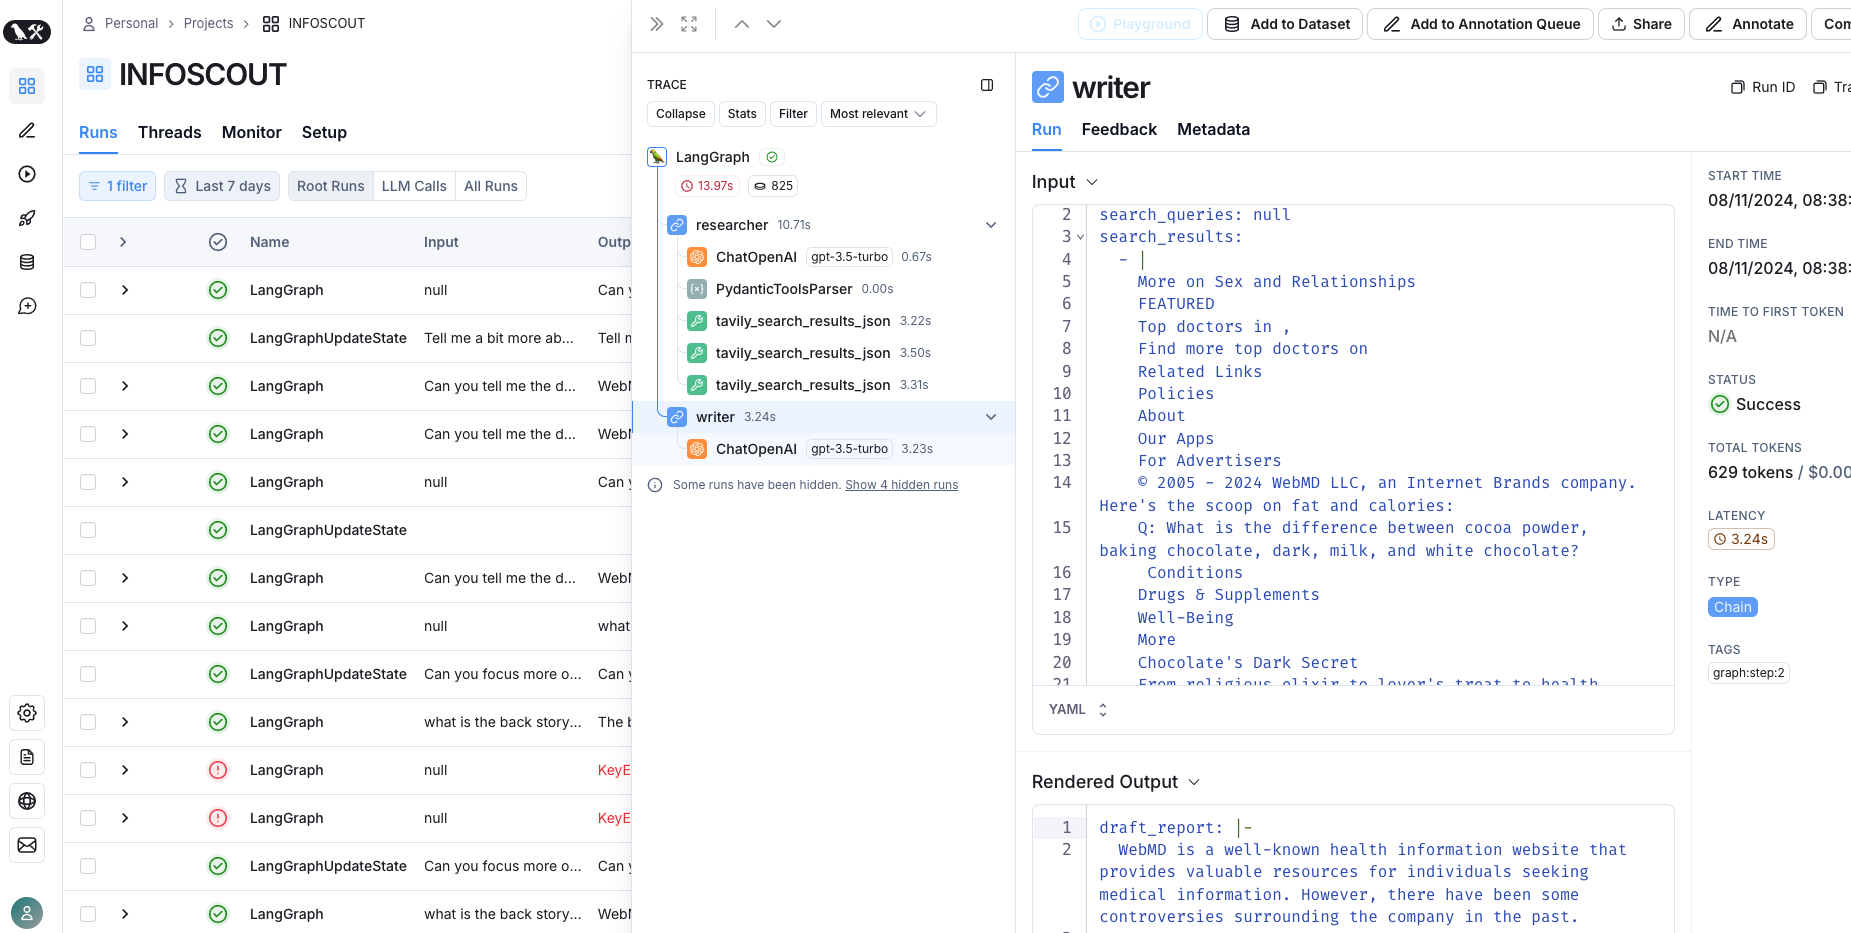

# Optional Learner Tasks:

## 📝 Better reviewer

In the graph above, we used `gpt-3.5-turbo` as the LLM for all of our tasks. However, it might make sense that we use a better (smarter?) LLM to perform the review of our article to get better feedback. Can you adapt the `reflection_node` to use a different LLM like say `gpt-4-turbo` or `claude`

In [ ]:
!pip install langchain-anthropic

In [ ]:
from langchain_anthropic import ChatAnthropic

model_name = "claude-3-sonnet"
reflection_llm = ChatAnthropic(
    model=model_name,
    api_key=userdata.get("CLAUDE_API_KEY")
)

def reflection_node(state: AgentState):
    ## Perform necessary adaptations to this function to make use of a different LLM

## 📝 Different output formats

In this graph, we focussed on generating an article. What if we could also consider other output formats like a LinkedIn post or a Twitter thread. Could you adapt the graph to add additional nodes that would use the draft article as input and generate a LinkedIn post or Twitter thread. Consider where would you add these nodes and what kind of new edges will be required.